In [1]:
import matplotlib
import pandas as pd
import numpy as np

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [3]:
import time
from datetime import datetime
from re import sub
def mdy_to_ymd(d):
    return time.mktime(datetime.strptime(d, '%d-%b-%y').timetuple())

class Beautify:

    @staticmethod
    def beautify(path):
        dataset = pd.read_csv(path)
        dataset.columns = ["date", "price", "open", "high", "low", "vol", "change"]
        dataset["date"] = dataset.apply(lambda row: mdy_to_ymd(row['date']), axis=1)
        for col in ["price", "open", "high", "low", "vol", "change"]:
            dataset[col] = dataset.apply(
                lambda row: (lambda x: 0 if x == '-' else float(x))(sub(r'[^\d.-]', '', row[col])),
                axis=1)
        dataset = dataset.sort_values(["date"])
        return dataset


pd.set_option('display.float_format', lambda x: '%.0f' % x)

In [4]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,7)

import seaborn as sns
from datetime import datetime, timedelta

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from scipy import stats
import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [5]:
dataset = Beautify.beautify("dataset.csv")

<AxesSubplot:xlabel='date'>

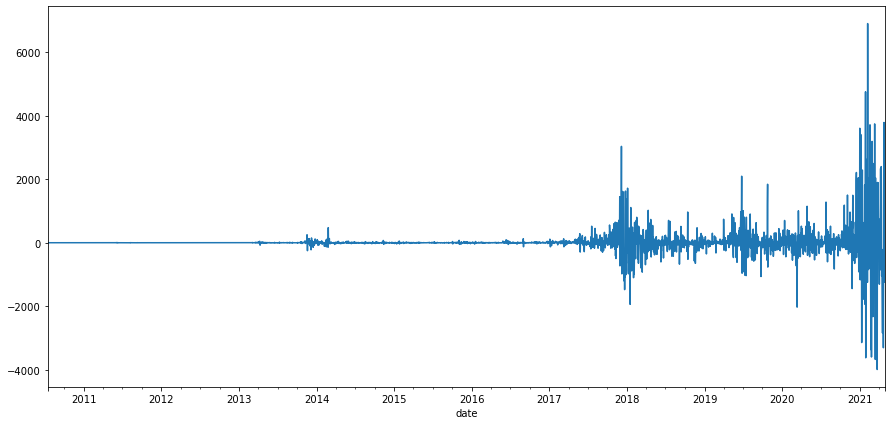

In [33]:
dataset["high"].diff().plot() # it changes based on time

In [6]:
dataset["date"] = dataset.apply(lambda x: datetime.utcfromtimestamp(x["date"]).strftime('%Y-%m-%d'),axis=1)

In [7]:
dataset = dataset[["date","open","low","high"]]

In [8]:
dataset["date"] = pd.to_datetime(dataset['date'])

In [9]:
dataset.set_index("date",inplace=True)

In [10]:
dataset_month = dataset

In [11]:
dataset_month['high_box'], lmbda = stats.boxcox(dataset_month.high)

<AxesSubplot:xlabel='date'>

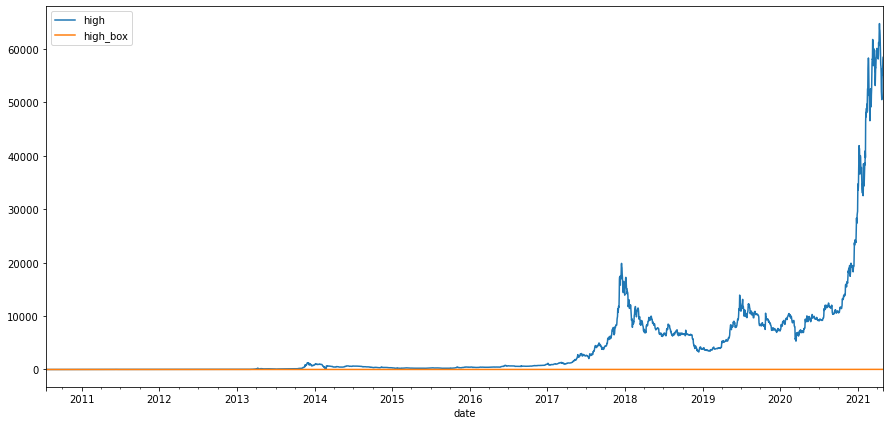

In [37]:
dataset_month[['high','high_box']].plot()

In [12]:
dataset_month['box_diff_seasonal_12'] = dataset_month.high_box - dataset_month.high_box.shift(12)


In [13]:
dataset_month['box_diff_seasonal_3'] = dataset_month.high_box - dataset_month.high_box.shift(3)

In [14]:
dataset_month['box_diff2'] = dataset_month.box_diff_seasonal_12 - dataset_month.box_diff_seasonal_12.shift(1)

In [15]:
qs = range(0, 3)
ps = range(0, 3)
d = 1
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)

results = []
best_aic = float("inf")
for param in parameters_list:
    try:
        model = SARIMAX(dataset_month.high_box, order=(param[0], d, param[1])).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

In [16]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

  parameters   aic
8     (2, 2) -6357
6     (2, 0) -6319
7     (2, 1) -6317
2     (0, 2) -6317
5     (1, 2) -6315


In [17]:
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

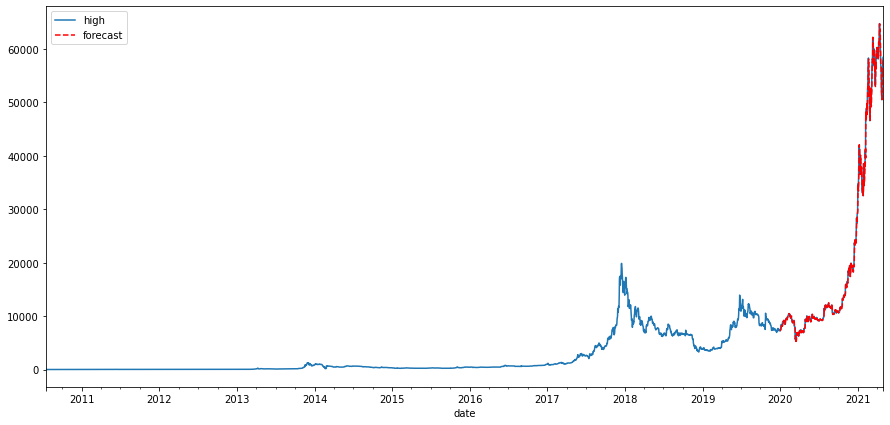

In [18]:
btc_month_pred = dataset_month[['high']]
btc_month_pred['forecast'] = invboxcox(best_model.predict(start=datetime(2020, 1, 2), end=datetime(2021, 5, 1)), lmbda)
plt.figure(figsize=(15,7))
btc_month_pred.high.plot()
btc_month_pred.forecast.plot(color='r', ls='--')
plt.legend()
plt.show()

In [19]:
mean_squared_error(btc_month_pred.forecast["2020-01-2":],dataset["2020-01-2":]["high"])

991126.3724217424

In [20]:
((btc_month_pred.forecast["2020-01-2":]*0.95<=dataset["2020-01-2":]["high"]) & (btc_month_pred.forecast["2020-01-2":]*1.05>=dataset["2020-01-2":]["high"])).shape[0]/btc_month_pred.forecast["2020-01-2":].shape[0]

1.0

In [24]:
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
results = []
best_aic = float("inf")
for param in parameters_list:
    print(param)
    try:
        model = SARIMAX(dataset_month.high_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4)).fit(disp=-1)
    except ValueError:
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 0)
(0, 0, 1, 1)
(0, 0, 2, 0)
(0, 0, 2, 1)
(0, 1, 0, 0)
(0, 1, 0, 1)
(0, 1, 1, 0)
(0, 1, 1, 1)
(0, 1, 2, 0)
(0, 1, 2, 1)
(0, 2, 0, 0)
(0, 2, 0, 1)
(0, 2, 1, 0)
(0, 2, 1, 1)
(0, 2, 2, 0)
(0, 2, 2, 1)
(1, 0, 0, 0)
(1, 0, 0, 1)
(1, 0, 1, 0)
(1, 0, 1, 1)
(1, 0, 2, 0)
(1, 0, 2, 1)
(1, 1, 0, 0)
(1, 1, 0, 1)
(1, 1, 1, 0)
(1, 1, 1, 1)
(1, 1, 2, 0)
(1, 1, 2, 1)
(1, 2, 0, 0)
(1, 2, 0, 1)
(1, 2, 1, 0)
(1, 2, 1, 1)
(1, 2, 2, 0)
(1, 2, 2, 1)
(2, 0, 0, 0)
(2, 0, 0, 1)
(2, 0, 1, 0)
(2, 0, 1, 1)
(2, 0, 2, 0)
(2, 0, 2, 1)
(2, 1, 0, 0)
(2, 1, 0, 1)
(2, 1, 1, 0)
(2, 1, 1, 1)
(2, 1, 2, 0)
(2, 1, 2, 1)
(2, 2, 0, 0)
(2, 2, 0, 1)
(2, 2, 1, 0)
(2, 2, 1, 1)
(2, 2, 2, 0)
(2, 2, 2, 1)


In [25]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']

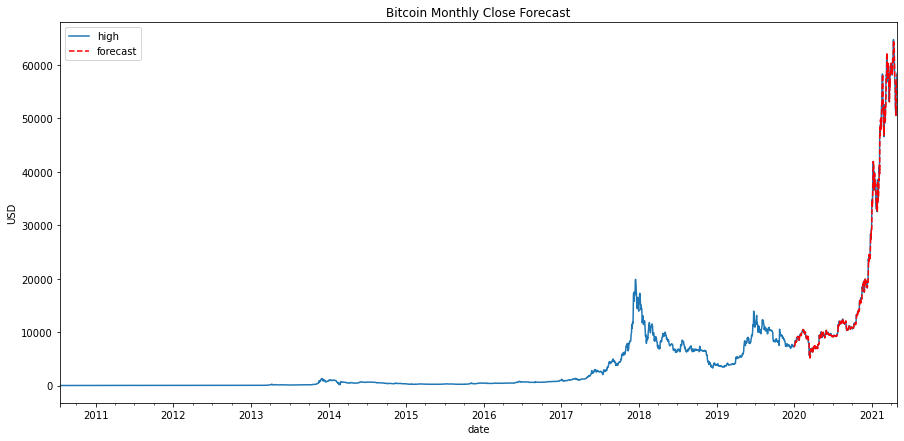

In [26]:
dataset_month2 = dataset_month[['high']]
date_list = [datetime(2018, 3, 31), datetime(2018, 4, 30), datetime(2018, 5, 31), datetime(2018, 6, 30)]
future = pd.DataFrame(index=date_list, columns= dataset_month.columns)
btc_month2 = pd.concat([dataset_month2, future])

dataset_month2['forecast'] = invboxcox(best_model.predict(start=datetime(2020, 1, 2), end=datetime(2021, 5, 1)), lmbda)

plt.figure(figsize=(15,7))
dataset_month2.high.plot()
dataset_month2.forecast.plot(color='r', ls='--', label='forecast')
plt.legend()
plt.title('Bitcoin Monthly Close Forecast')
plt.ylabel('USD')
plt.show()

In [27]:
mean_squared_error(dataset_month2.forecast["2020-01-2":],dataset["2020-01-2":]["high"])

983733.142318476

In [28]:
((dataset_month2.forecast["2020-01-2":]*0.95<=dataset["2020-01-2":]["high"]) & (dataset_month2.forecast["2020-01-2":]*1.05>=dataset["2020-01-2":]["high"])).shape[0]/dataset_month2.forecast["2020-01-2":].shape[0]

1.0

In [ ]:
# SARIMAX(dataset_month.high_box, order=(param[0], d, param[1]))
# SARIMAX(dataset_month.high_box, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], 4))